# Gutenberg


**Project Gutenberg is a library of over 60,000 free eBooks**

![Gutenberg](https://drive.google.com/uc?export=view&id=1bOd8Hiv-sU8Skj1gYR-2cxLUEBIretyZ)


**Recommended to use GPU to run much faster.
But it works well with the CPU also.**
- GPU takes around 40 mins, while CPU may take hours.

# Project Methodology

![Gutenberg](https://drive.google.com/uc?export=view&id=1-YX8_vqTOSjudFe5AiovLCDzA6SEOhLm)

# Project Main Steps


- [Data Exploration](#1)
- [Data Preprocessing](#2)
- [Word Embedding](#3)
  - [BOW](#4)
  - [TF-IDF](#5)
  - [Doc2Vec](#6)
  - [Bert Embedding](#7)
  - [Glove](#8)
  - [Fast text](#9)
  - [Word2Vec](#10)
  - [LDA (Linear Discriminant Analysis)](#11)
- [Word embedding dictionary](#12)
- [Training](#13)
- [BERT classifier](#14)
- [Validation](#15)
- [Error analysis](#16)
  - [Reduce the samples' word number](#17)
  - [Word Counts](#18)
- [Grid Search](#19)
- [Conclusion](#20)

### Install nltk library and download Gutenberg's digital books

In [1]:
!pip install nltk

In [2]:
import numpy as np
import pandas as pd
import nltk

nltk.download('gutenberg')
books_names=nltk.corpus.gutenberg.fileids()
books_names

[nltk_data] Downloading package gutenberg to /usr/share/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

# <a id="1">Data Exploration</a>

<h3>Choose 5 books from the same category and different authors<h3>

In [3]:
books_idx=[12,8,11,0,5]
selected_books=[]
for idx in books_idx :
  selected_books.append(books_names[idx])
print(selected_books)

['melville-moby_dick.txt', 'chesterton-ball.txt', 'edgeworth-parents.txt', 'austen-emma.txt', 'bryant-stories.txt']


### Discover these books' content

In [4]:
book_contents=[]
for book_name in selected_books:
  book_contents.append(nltk.corpus.gutenberg.raw(book_name))
book_contents[0][1:100]

'Moby Dick by Herman Melville 1851]\r\n\r\n\r\nETYMOLOGY.\r\n\r\n(Supplied by a Late Consumptive Usher to a Gr'

> - Many problems have been found in books' content, so we should deal with them.

# <a id="2">Data Preprocessing</a>

### Clean the content of the books by:
- Removing the word capitalization, unwanted characters, white spaces, and stop words.
- Replacing some patterns.
- Applying lemmatization and tokenization.

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
import re

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    #remove punctuation and strange characters
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"
    #remove stop words
    stop_words = stopwords.words('english') + ['never','ever','couldnot','wouldnot','could','would','us',"i'm","you'd"]
    lower_book = text.lower()                                              # Converting all words into lower case.
    filtered_book = re.sub(sub_pattern,' ',lower_book).lstrip().rstrip()   # Replacing all characters except those in the pattern into spaces.
    filtered_book = word_tokenize(filtered_book)                      # tokenizethe whole book into words in a list.
    filtered_book = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_book if word not in stop_words]
    return filtered_book


In [7]:
cleaned_books_contents=[]
for book in book_contents :
  cleaned_books_contents.append(clean_text(book))
cleaned_books_contents[0][1:30]

['dick',
 'herman',
 'melville',
 'etymology',
 'supply',
 'late',
 'consumptive',
 'usher',
 'grammar',
 'school',
 'pale',
 'usher',
 'threadbare',
 'coat',
 'heart',
 'body',
 'brain',
 'see',
 'dust',
 'old',
 'lexicon',
 'grammar',
 'queer',
 'handkerchief',
 'mockingly',
 'embellish',
 'gay',
 'flag',
 'know']

### Create 200 random samples from each book, where each sample contains 100 words.

In [8]:
def book_samples(book,n_samples) :
    import random
    samples=[]
    start=0
    while start +100 < len(book)-1:
        temp1=""
        for j in range(start,start+n_samples):
            temp1+= book[j] + " "
        samples.append(temp1)
        start+=100
    random_samples_index=random.sample(range(0,len(samples)),k=min(200,len(samples)))
    partitions=[]
    for idx in random_samples_index :
        partitions.append(samples[idx])
    return partitions

In [9]:
samples_of_books=[]
for cleaned_book in cleaned_books_contents :
  samples_of_books.append(book_samples(cleaned_book,100))
samples_of_books[0][0]

'watchmaker sailor put hone porpoise meat good eat know may occur porpoise spout indeed spout small readily discernible next time chance watch see great sperm whale miniature book iii duodecimo chapter ii algerine porpoise pirate savage found think pacific somewhat large huzza porpoise much general make provoke buckle shark lower many time yet saw capture book iii duodecimo chapter iii mealy mouth porpoise large kind porpoise found pacific far know english name hitherto designate fisher right whale porpoise circumstance chiefly found vicinity folio shape differs degree huzza porpoise less rotund jolly girth indeed quite neat gentleman like figure fin back '

### Create a data frame containing 2 columns and 1000 rows representing the books' samples (Sample) and the book name (Label).

|id|book sample | book name (label)|
|--|--|--|
||||

In [10]:
import pandas as pd
data_frame =pd.DataFrame()
data_frame['Sample of the book']=[item for sublist in samples_of_books for item in sublist]
target=[[selected_books[i]]*min(200,len(samples_of_books[i])) for i in range(len(selected_books)) ]
data_frame['Book_name']=[item for sublist in target for item in sublist]
data_frame['Book_name'].unique()

array(['melville-moby_dick.txt', 'chesterton-ball.txt',
       'edgeworth-parents.txt', 'austen-emma.txt', 'bryant-stories.txt'],
      dtype=object)

<h3>Shuffling the dataset

In [11]:
from sklearn.utils import shuffle
data_frame = shuffle(data_frame)
data_frame

,Sample of the book,Book_name
169,whence come eyed real phantom ask sun moon cre...,melville-moby_dick.txt
172,encounter sperm whale whose sole knowledge lev...,melville-moby_dick.txt
967,take command piccola poor sweet piccola hear h...,bryant-stories.txt
899,inside story heard little shiver bird sparrow ...,bryant-stories.txt
2,rising say stay eleven minute jet seventy time...,melville-moby_dick.txt
...,...,...
97,prepared great fish swallow jonah jonah go shi...,melville-moby_dick.txt
627,felt certain preference preference believe des...,austen-emma.txt
207,science one think protoplasm naturally prefer ...,chesterton-ball.txt
893,pioneer atlantic coast cross mississippi river...,bryant-stories.txt


In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
y= label_encoder.fit_transform(data_frame['Book_name'])
data_frame['Book_name']=y

In [13]:
# you can save the data as a dataset.csv file by run this line
# data_frame.to_csv('dataset.csv')

----------------------------------------

## Train Test Split

In [14]:
from sklearn.model_selection import train_test_split
df_train, df_test= train_test_split(data_frame,test_size=0.2,random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(data_frame['Sample of the book'], data_frame['Book_name'], random_state = 0,test_size=0.2)
df_train

,Sample of the book,Book_name
606,elton one whose assistance ask invite contribu...,0
38,observe eye ear side head nearly one third ent...,4
462,sixpence jem heard say get amongst neighbour r...,3
378,head foremost private cell private room till d...,2
271,upright slender rigid figure grip side seat fi...,2
...,...,...
495,sir intend poison dog save life lord bless say...,3
194,afterwards take fish ergo aforesaid article co...,4
470,must help one another sure add betty susan tho...,3
252,go say evan burning eye sight sin offends god ...,2


# <a id="3">Word Embedding</a>

It is one of the trivial steps to be followed for a better understanding of the context of what we are dealing with. After the initial text is cleaned and normalized, we need to transform it into its features to be used for modeling.

We used some methods to assign weights to particular words, sentences, or documents within our data before modeling them. We go for numerical representation for individual words as it’s easy for the computer to process numbers.

## <a id="4">BOW</a>

A bag of words is a representation of text that describes the occurrence of words within a document, that just keeps track of word counts and disregards the grammatical details and the word order.
As we said that we split the data. So, we applied BOW to training and testing data.
So, it transforms each sentence into an array of occurrences in this sentence.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

BOW = CountVectorizer()
BOW_train = BOW.fit_transform(X_train)
BOW_test = BOW.transform(X_test)
BOW_train.shape

(800, 9300)

Apply Linear discriminant analysis (LDA) on Bow to reduce its dimensions. as it's vector shape very large.

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
lda_train = lda.fit_transform(BOW_train.toarray(), y_train)
lda_test = lda.transform(BOW_test.toarray())
lda_test.shape

(200, 4)

## <a id="5">TF-IDF</a>


TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

In addition, to understand the relation between each consecutive pair of words, tfidf with bigram has applied.
Furthermore, we applied tfidf with trigram to find out wether there is a relation between each consecutive three words.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_ngram(n_gram,X_train=X_train,X_test=X_test):
    vectorizer = TfidfVectorizer(ngram_range=(1,n_gram))
    x_train_vec = vectorizer.fit_transform(X_train)
    x_test_vec = vectorizer.transform(X_test)
    return x_train_vec,x_test_vec 

### Applying tfidf with Uni-gram, and BI-gram

In [18]:
X_trained1g_cv,X_test1g_cv = tfidf_ngram(1,X_train=X_train,X_test=X_test)
X_trained2g_cv,X_test2g_cv = tfidf_ngram(2,X_train=X_train,X_test=X_test)

## <a id="6">Doc2Vec</a>
- Doc2Vec is a method for representing a document as a vector and is built on the word2vec approach.
- I have trained a model from scratch to embed each sentence or paragraph of the data frame as a vector of 50 elements.

In [19]:
#Import packages
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
# Tokenization of each document
tokenized_doc = []
for d in df_train['Sample of the book']:
    tokenized_doc.append(word_tokenize(d.lower()))

# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
tagged_data[0]

TaggedDocument(words=['elton', 'one', 'whose', 'assistance', 'ask', 'invite', 'contribute', 'really', 'good', 'enigma', 'charade', 'conundrum', 'might', 'recollect', 'pleasure', 'see', 'intently', 'work', 'recollection', 'time', 'perceive', 'earnestly', 'careful', 'nothing', 'ungallant', 'nothing', 'breathe', 'compliment', 'sex', 'pas', 'lip', 'owe', 'two', 'three', 'politest', 'puzzle', 'joy', 'exultation', 'last', 'recall', 'rather', 'sentimentally', 'recite', 'well', 'know', 'charade', 'first', 'doth', 'affliction', 'denote', 'second', 'destin', 'feel', 'whole', 'best', 'antidote', 'affliction', 'soften', 'heal', 'make', 'quite', 'sorry', 'acknowledge', 'transcribed', 'page', 'ago', 'already', 'write', 'one', 'mr', 'elton', 'say', 'security', 'freshness', 'nothing', 'easy', 'oh', 'write', 'hardly', 'thing', 'kind', 'life', 'stupidest', 'fellow', 'afraid', 'even', 'miss', 'woodhouse', 'stopt', 'moment', 'miss', 'smith', 'inspire', 'next', 'day', 'however', 'produce', 'proof', 'inspir

In [20]:
## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size=50, window=2, min_count=1, workers=4, epochs = 100)
# Save trained doc2vec model
# model.save("test_doc2vec.model")

In [21]:
## Load saved doc2vec model
# model= Doc2Vec.load("test_doc2vec.model")
## Print model vocabulary
def get_doc2vec_vector(df):
    doc2vec_vectors=[]
    for sentence in df['Sample of the book']:
        doc2vec_vectors.append(model.infer_vector(word_tokenize(sentence.lower())))
    return doc2vec_vectors
train_doc2vec_vectors=get_doc2vec_vector(df_train)
test_doc2vec_vectors=get_doc2vec_vector(df_test)
len(train_doc2vec_vectors)

800

## <a id="7">Using BERT as pretrained model</a>

Bert can be used as a word embedding pretrained model and then use these embedded vectors to train another model like SVM or Naive bayes and DL models like RNN or LSTM 

- BERT (Bidirectional Encoder Representations from Transformers) is a highly complex and advanced language model that helps people automate language understanding.
- BERT is the encoder of transformers, and it consists of 12 layers in the base model, and 24 layers for the large model. So, we can take the output of these layers as an embedding vector from the pre-trained model.
- There are three approaches to the embedding vectors: concatenate the last four layers, the sum of the last four layers, or embed the full sentence by taking the mean of the embedding vectors of the tokenized words
- As the first two methods require computational power, we used the third one which takes the mean of columns of each word and each word is represented as a 768x1 vector. so, the whole sentence at the end is represented as a 768x1 vector

In [22]:
!pip install transformers

**Check the GPU**

In [23]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [24]:
# Import Libraries
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel
from keras_preprocessing.sequence import pad_sequences
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def sentence_embedding_BERT(sentences):
    # Create sentence and label lists
    # We need to add special tokens at the beginning and end of each sentence for BERT to work properly
    sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
    labels = data_frame.Book_name.values

    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Tokenize the sentences and put them in the list tokenized_texts
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    # Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
    # In the original paper, the authors used a length of 512.
    MAX_LEN = 128
    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # Pad our input tokens
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    attention_masks = []
    hidden_states=[]
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)
    # Conver the ids into a tensor representation
    batch_size = 4
    input_tensor = torch.tensor(input_ids)
    masks_tensor = torch.tensor(attention_masks)
    train_data = TensorDataset(input_tensor, masks_tensor)
    dataloader = DataLoader(train_data, batch_size=batch_size)
    # Initialize the model
    if torch.cuda.is_available():
        model = BertModel.from_pretrained("bert-base-uncased",output_hidden_states = True,).to('cuda')
    else:
        model = BertModel.from_pretrained("bert-base-uncased",output_hidden_states = True,).to('cpu')
    model.eval()
    outputs = []
    for input, masks in dataloader:
        torch.cuda.empty_cache() # empty the gpu memory
        # Transfer the batch to gp
        if torch.cuda.is_available():
            input = input.to('cuda')
            masks = masks.to('cuda')
        # Run inference on the batch
        output = model(input, attention_mask=masks)
        # Transfer the output to CPU again and convert to numpy
        output = output[0].cpu().detach().numpy()
        # Store the output in a list
        outputs.append(output)

    # Concatenate all the lists within the list into one list
    outputs = [x for y in outputs for x in y]
    outputs=np.array(outputs)
    return outputs.mean(axis=1)

**Embed the full sectence by taking the mean of the embedding vectors of the tokenized words**

In [25]:
# sentence_embedding_BERT()
BERT_embedding_vectors_train=sentence_embedding_BERT(df_train['Sample of the book'])
BERT_embedding_vectors_test= sentence_embedding_BERT(df_test['Sample of the book'])
BERT_embedding_vectors_train.shape

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 

(800, 768)

## Helper function

In [26]:
import gensim.downloader as api
def get_vectors_pretrained(df, model):
    embedding_vectors = []
    for partition in df['Sample of the book']:
        sentence = []
        for word in partition.split(' '):
            try:
                sentence.append(model[word])
            except:
                pass
        sentence = np.array(sentence)
        sentence = sentence.mean(axis=0)
        embedding_vectors.append(sentence)
    embedding_vectors = np.array(embedding_vectors)
    return embedding_vectors

## <a id="8">Glove</a>
- Global vector for word representation is an unsupervised learning algorithm for word embedding.
- We trained a GloVe model on books’ data, that represents each word in a 300x1 Vector. We took the data frame after cleaning and get each paragraph and passed it to the corpus. After that,t we trained the model on each word.
- We used also a pre-trained model “glove-wiki-gigaword-300”. Each word is represented by a 300x1 vector. Then, on each word of a sentence in the data frame, we replaced it with its vector representation.

In [27]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-300")  # load glove vectors
train_glove_embedding_vectors=get_vectors_pretrained(df_train,glove_model)
test_glove_embedding_vectors=get_vectors_pretrained(df_test,glove_model)
print(train_glove_embedding_vectors.shape)

[=================================================-] 99.4% 373.8/376.1MB downloaded
(800, 300)


## <a id="9">Fast text</a>
- FastText is a library for learning word embeddings and text classification. The model allows one to create unsupervised learning or supervised learning algorithms for obtaining vector representations for words.
- We loaded a pre-trained model from genism API ‘fasttext-wiki-news-subwords-300’.

In [28]:
import gensim.downloader as api
fast_text_model = api.load("fasttext-wiki-news-subwords-300")  # load glove vectors
train_fast_text_embedding_vectors=get_vectors_pretrained(df_train,glove_model)
test_fast_text_embedding_vectors=get_vectors_pretrained(df_test,glove_model)
print(train_fast_text_embedding_vectors.shape)

[==================================================] 100.0% 958.5/958.4MB downloaded
(800, 300)


## <a id="10">Word2Vec</a>
- Word2vec is a method to represent each word as a vector.
- Used a pre-trained model “word2vec-google-news-300”.

In [29]:
import gensim.downloader as api
word2vec_model = api.load("word2vec-google-news-300")  # load glove vectors
train_word2vec_embedding_vectors= get_vectors_pretrained(df_train,word2vec_model)
test_word2vec_embedding_vectors= get_vectors_pretrained(df_test,word2vec_model)
print(train_word2vec_embedding_vectors.shape)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
(800, 300)


## <a id="11">LDA (Linear Discriminant Analysis)</a>

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
lda_train = lda.fit_transform(BOW_train.toarray(), y_train)
lda_test = lda.transform(BOW_test.toarray())

# <a id="12">Word embedding dictionary</a>

In [31]:
text_embedding={
    'BOW':(BOW_train,BOW_test),
    'TF_IDF 1_gram':(X_trained1g_cv,X_test1g_cv),
    'TF_IDF 2_gram':(X_trained2g_cv,X_test2g_cv),
    'Doc2vec':(train_doc2vec_vectors,test_doc2vec_vectors),
    'LDA' :(lda_train,lda_test),
    # optional embedding
    'Glove':(train_glove_embedding_vectors,test_glove_embedding_vectors),
    'Word2vec':(train_word2vec_embedding_vectors,test_word2vec_embedding_vectors),
    'BERT Model':(BERT_embedding_vectors_train,BERT_embedding_vectors_test),
}

### Save word Embedding as a pickle file 
For future use, the embedding takes a long time. So, if you want to start directly with the embedded data that has been computed previously.

In [32]:
import pickle
a_file = open("Embedding_Vectors_Classification.pkl", "wb")
pickle.dump(text_embedding, a_file)
a_file.close()
print('Saved')

Saved


# <a id="13">Choosing the Champion model and champion embedding method</a>

Train Models:
SVM is a supervised machine learning algorithm that separates classes using hyperplanes.

• Gaussian NB is special type of Naïve Bayes algorithm that perform well on continuous data.

• KNN is a non-parametric supervised algorithm. Despite its simplicity it can be highly competitive in NLP applications.

• Decision Tree uses a tree-like model in to take a decision and studying its consequences.

So, we have 32 models on all of our transformation methods.

In [33]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [34]:
models = [SVC(), 
          GaussianNB(),
          KNeighborsClassifier(),
          DecisionTreeClassifier(max_depth=10)
          ]
highest_test_accuracy=0
champion_model_name=''
champion_model=''
champion_embedding=''
results_dict={'Model Name':[],'Embedding type':[],'Training Accuracy':[],'Testing Accuracy':[]}

for model in models:
  for embedding_vector in text_embedding.keys():
    if 'gram' in embedding_vector or 'BOW' in embedding_vector :
        train=text_embedding[embedding_vector][0].toarray()
        test=text_embedding[embedding_vector][1].toarray()
    else :
        train=text_embedding[embedding_vector][0]
        test=text_embedding[embedding_vector][1]
    model.fit(train, y_train)

    results_dict['Model Name'].append(type(model).__name__)
    results_dict['Embedding type'].append(embedding_vector)
    train_acc=model.score(train, y_train)
    results_dict['Training Accuracy'].append(train_acc)
    test_acc=model.score(test, y_test)
    results_dict['Testing Accuracy'].append(test_acc)
    
    if test_acc > highest_test_accuracy:
      highest_test_accuracy=test_acc
      champion_model_name=type(model).__name__
      champion_model=model
      champion_embedding=embedding_vector

results_df=pd.DataFrame(results_dict)

print('champion_model is ',champion_model_name)
print('champion_embedding is',champion_embedding)

champion_model is  SVC
champion_embedding is TF_IDF 2_gram


In [35]:
results_df

,Model Name,Embedding type,Training Accuracy,Testing Accuracy
0,SVC,BOW,1.00000,0.965
1,SVC,TF_IDF 1_gram,1.00000,0.990
2,SVC,TF_IDF 2_gram,1.00000,1.000
3,SVC,Doc2vec,0.99875,0.985
4,SVC,LDA,0.79625,0.630
5,SVC,Glove,0.94375,0.935
6,SVC,Word2vec,0.95875,0.920
7,SVC,BERT Model,0.94250,0.910
8,GaussianNB,BOW,1.00000,0.975
9,GaussianNB,TF_IDF 1_gram,1.00000,0.960


In [36]:
results_df['Model Name']=results_df['Model Name'].apply(lambda x: x[:-10] if 'Classifier' in x else x)
results_df

,Model Name,Embedding type,Training Accuracy,Testing Accuracy
0,SVC,BOW,1.00000,0.965
1,SVC,TF_IDF 1_gram,1.00000,0.990
2,SVC,TF_IDF 2_gram,1.00000,1.000
3,SVC,Doc2vec,0.99875,0.985
4,SVC,LDA,0.79625,0.630
5,SVC,Glove,0.94375,0.935
6,SVC,Word2vec,0.95875,0.920
7,SVC,BERT Model,0.94250,0.910
8,GaussianNB,BOW,1.00000,0.975
9,GaussianNB,TF_IDF 1_gram,1.00000,0.960


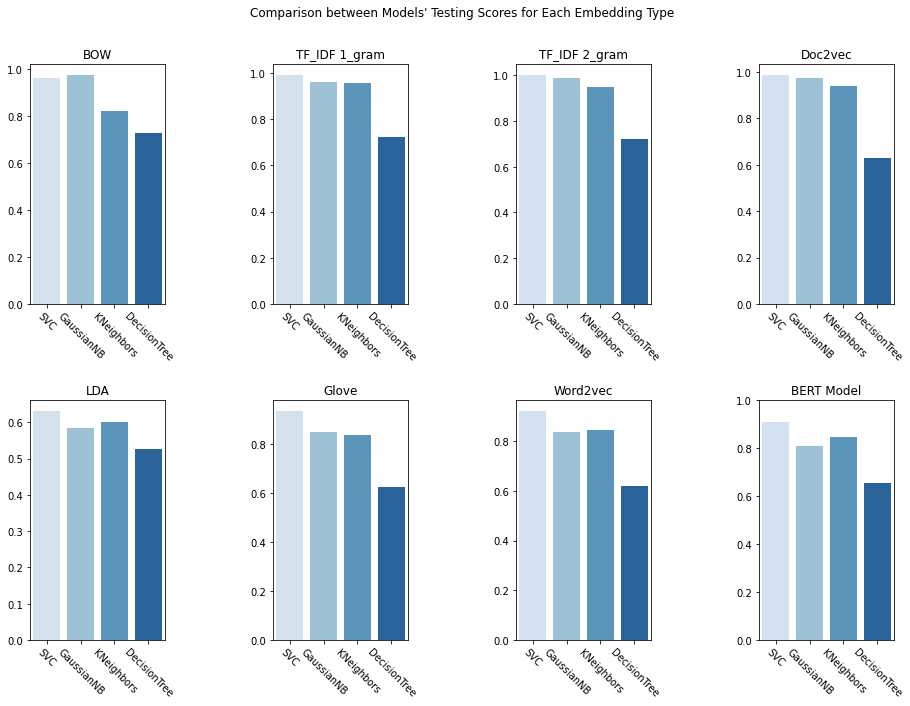

In [37]:
import seaborn as sns
fig, axes = plt.subplots(2, (results_df['Embedding type'].nunique()//2), figsize=(15,10));
fig.suptitle("Comparison between Models' Testing Scores for Each Embedding Type" );
k = 0
for i in range (0,2):
    for j in range (0,4):
        embed_type = results_df['Embedding type'].unique()[k]
        plt.ylim((0,1));
        axes[i][j].tick_params(axis='x', rotation=-45)
        axes[i][j].set_title(f"{embed_type}");
        sns.barplot(ax = axes[i][j], x= list(results_df['Model Name'].unique()), y=list(results_df[results_df['Embedding type'] == embed_type]['Testing Accuracy']),palette="Blues");
        k+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.8,
                    hspace=0.4)

In [38]:
results_df.to_csv('results.csv',index=False)

In [39]:
#read cvs file
results_df=pd.read_csv('results.csv')
results_df

,Model Name,Embedding type,Training Accuracy,Testing Accuracy
0,SVC,BOW,1.00000,0.965
1,SVC,TF_IDF 1_gram,1.00000,0.990
2,SVC,TF_IDF 2_gram,1.00000,1.000
3,SVC,Doc2vec,0.99875,0.985
4,SVC,LDA,0.79625,0.630
5,SVC,Glove,0.94375,0.935
6,SVC,Word2vec,0.95875,0.920
7,SVC,BERT Model,0.94250,0.910
8,GaussianNB,BOW,1.00000,0.975
9,GaussianNB,TF_IDF 1_gram,1.00000,0.960


## <a id="14">BERT classifier</a>

- BERT can be used as the main classifier by fine tuning the model on our dataset.
- Used implemented BERT class from hugging face library which called transformers.

In [40]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=1b2faaed6a9070bc763b1f42705e589459d7228f8cd433fe7c6dd18dd53a2450
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=52c6ab813d9f69b7565a3e6bd9406bf6fe0c6ae6e401684bd0e0dcaa0d775378
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8

In [41]:
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
# Defining Model
model = ClassificationModel('bert', 'bert-base-uncased',
                            use_cuda= torch.cuda.is_available(),
                            args={'reprocess_input_data': True,
                            'overwrite_output_dir': True},
                            num_labels=5,)
# train the model
model.train_model(df_train)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/800 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/100 [00:00<?, ?it/s]

(100, 1.101823272705078)

In [42]:
# validate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df=df_train,acc=accuracy_score)
print('Training Accuracy',result['acc'])
result, model_outputs, wrong_predictions = model.eval_model(eval_df=df_test,acc=accuracy_score)
print('Testing  Accuracy',result['acc'])

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/800 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Training Accuracy 0.8575


/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/200 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Testing  Accuracy 0.88


<AxesSubplot:>

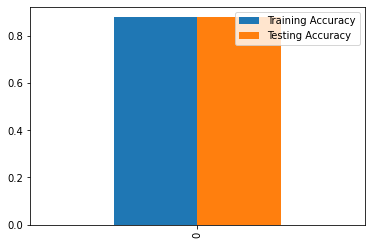

In [43]:
bert_acc_df=pd.DataFrame({"Training Accuracy":[result['acc']],"Testing Accuracy":[result['acc']]})
bert_acc_df.plot(kind='bar')

- **From the results above, the best accuracy comes from the SVC classifier trained on the TF-IDF uni-gram embedding vector and the achieving training accuracy is 100% and testing accuracy is 99.5%.**

# <a id="15">Validation</a>

Applied the 10-fold cross-validation to estimate the skills of our machine learning models on different combinations of validation and training datasets.

In [44]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

%matplotlib inline
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def plot_cv_indices(kfold_object,model_name,X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(kfold_object.split(X=X, y=y,groups=None)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(np.array(X)))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)),
            [ii + 0.5] * len(indices),c=indices,marker="_",
            lw=lw,cmap=cmap_cv,vmin=-0.2,vmax=1.2,)

        # Plot the data classes and groups at the end
        ax.scatter(range(len(np.array(X))), [ii + 1.5] * len(np.array(X)), c=np.array(y), marker="_", lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits+2)) + ["class"]
    ax.set(
        xlabel="Sample index",
        ylabel="CV iteration",
    )
    ax.set_title(f" KFold with {model_name} Model", fontsize=15)
    return ax

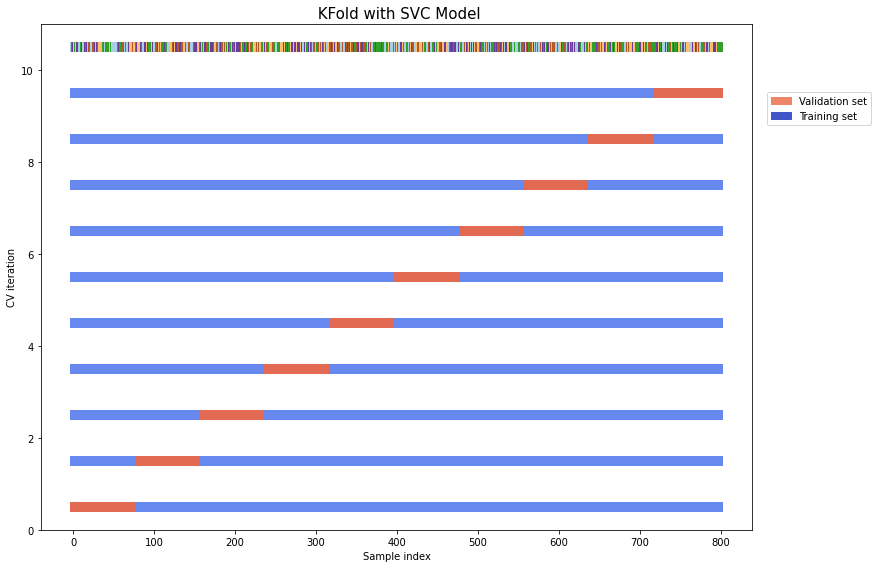

In [45]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(15,8));
plot_cv_indices(KFold(10),model_name= 'SVC', X= X_train, y= y_train,ax=ax, n_splits=10, lw=10);
ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Validation set", "Training set"],
    loc=(1.02, 0.8),
);
# Make the legend fit
plt.tight_layout();
fig.subplots_adjust(right=0.7);
plt.show();

## Cross validation on the champion model

<h3> Champion model is support vector classifier (SVC) with Tf_idf transformation using uni gram<br>
which achivied Training accuracy 1.0 and Testing accuracy 0.965

In [46]:
output_cv=cross_validate(SVC(),X_trained1g_cv.toarray(),y_train,cv=10,return_estimator=True)
model_cv=output_cv['estimator'][output_cv['test_score'].argmax()]
print(f'Model testing accuracy is {model_cv.score(X_test1g_cv.toarray(),y_test)}')
y_pred=model_cv.predict(X_test1g_cv.toarray())

Model testing accuracy is 0.99


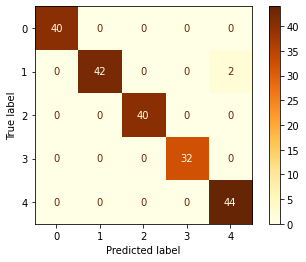

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay ,confusion_matrix,plot_confusion_matrix
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap='YlOrBr',)
plt.grid(False)

# <a id="16">Error analysis</a>

**Filter the wrong classified samples**

In [48]:
wrongs= y_pred !=y_test
X_test[wrongs]

810    lie green pasture leadeth beside still water r...
857    woman afterward maybe like hear poem write fou...
Name: Sample of the book, dtype: object

In [49]:
corrects_predictions =y_test[wrongs]
corrects_names=label_encoder.inverse_transform(corrects_predictions.to_list())
corrects_names.tolist()

['bryant-stories.txt', 'bryant-stories.txt']

In [50]:
predictions=y_pred[wrongs]
prediction_names=label_encoder.inverse_transform(predictions)
prediction_names

array(['melville-moby_dick.txt', 'melville-moby_dick.txt'], dtype=object)

### <a id="17">Reduce the number of training words</a>

Reduced the number of words in each sentence to test if the accuracy of the champion model will decrease, increase, or will still be the same.

In [51]:
def try_different_num_of_word (n=100):
    df_train_50_word=df_train['Sample of the book'].apply(lambda x : x[0:n])
    df_test_50_word=df_test['Sample of the book'].apply(lambda x : x[0:n])
    X_trained1g_50,X_test1g_50 = tfidf_ngram(1,X_train=df_train_50_word,X_test=X_test)
    champion_model.fit(X_trained1g_50.toarray(),y_train)
    test_acc=champion_model.score(X_test1g_50.toarray(),y_test)
    return test_acc

In [52]:
for i in [70,50,40,30,20] :
    print(f'Number of samples {i} , Testing Accuracy {try_different_num_of_word (n=i)}')

Number of samples 70 , Testing Accuracy 0.935
Number of samples 50 , Testing Accuracy 0.895
Number of samples 40 , Testing Accuracy 0.9
Number of samples 30 , Testing Accuracy 0.85
Number of samples 20 , Testing Accuracy 0.79


> - We noticed that the accuracy decreased by decreasing the number of words in each partition and this makes sense because the model can’t classify which class when the number of words(features) is small.

### <a id="18">Word Counts</a> 
So, we will explore the frequency of the words examples in the wrong and correct books

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from collections import Counter
example_freq=Counter(word_tokenize(X_test[wrongs].iloc[0]))
wrong_book_freq=Counter(cleaned_books_contents[0])
correct_book_freq=Counter(cleaned_books_contents[2])
word_freq=pd.DataFrame()
word_freq.index=word_tokenize(X_test[wrongs].iloc[0])
word_freq['Example']=0
word_freq['Wrong']=0
word_freq['Correct']=0
word_freq['Wrong is greater than']=0
for word in word_tokenize(X_test[wrongs].iloc[0]) :
    word_freq.loc[word,'Example']=example_freq[word]
    word_freq.loc[word,'Wrong']=wrong_book_freq[word]
    word_freq.loc[word,'Correct']=correct_book_freq[word]
    if wrong_book_freq[word]>correct_book_freq[word] :
        word_freq.loc[word,'Wrong is greater than']=1
word_freq

,Example,Wrong,Correct,Wrong is greater than
lie,1,67,49,1
green,1,54,44,1
pasture,1,7,1,1
leadeth,2,0,0,0
beside,1,6,28,0
...,...,...,...,...
perfect,1,4,5,0
one,2,940,515,1
stone,1,22,31,0
god,2,180,20,1


In [54]:
word_freq['Wrong is greater than'].value_counts()

1    50
0    50
Name: Wrong is greater than, dtype: int64

- At first, we explored the weights of word examples in correct and wrong book classification to make sure that everything is working fine.

# <a id="19">Grid Search</a> On the champion model

In [55]:
from sklearn.model_selection import GridSearchCV
param={
    'kernel' :['rbf','linear'],
    'C':[1,10],
}
clf=GridSearchCV (model_cv,param_grid=param)
clf.fit(X_trained1g_cv.toarray(),y_train)
print(f'Training Accuracy = {clf.score(X_trained1g_cv.toarray(),y_train)}')
print(f'Testing  Accuracy = {clf.score(X_test1g_cv.toarray(),y_test)}')
clf.best_params_

Training Accuracy = 1.0
Testing  Accuracy = 0.995


{'C': 10, 'kernel': 'linear'}

- We found that the best hyperparameter is a linear kernel with a regularization coefficient equal to 1.

# <a id="20">Conclusion:</a>
To wrap up, we made 32 model on different transformation methods and it was obvious that SVM perform better than other models, this is because the data is slightly few, and SVM performs better when data is small. When comparing transformation methods, it clear that TF-IDF uni-gram is trained better in most of the models, because as the length of n-grams increase, the frequency of finding this n-grams again decreases.